Plots environments into a single graph, in order to be put on the paper.

In [1]:
import sys
sys.path.append('../.')

import pandas as pd
from environment import Environment
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
plt.rcParams.update({'font.size': 22})

In [2]:
xian = Environment(Path(f"./xian"))
diamond = Environment(Path(f"./diamond_5x5"))
dilemma = Environment(Path(f"./dilemma_5x5"))
amsterdam = Environment(Path(f"./amsterdam/"))

No groups file provided. Trying to use the default groups file.


/home/lo/anaconda3/envs/fair-nw-expansion-linux/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1650977166858/work/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


No groups file provided. Trying to use the default groups file.
No groups file provided. Trying to use the default groups file.
No groups file provided. Trying to use the default groups file.


In [3]:
def calculate_agg_od(environment):
    """Calculate aggregate origin-destination flow matrix for each grid square of the given environment.

    Args:
        environment (Environment): environment for which to calcualte aggregate OD per grid square.

    Returns:
        torch.Tensor: aggregate od by grid
    """
    # 
    # A measure of importance of each square.
    agg_od_g = torch.zeros((environment.grid_x_size, environment.grid_y_size)).to(device)
    agg_od_v = environment.od_mx.sum(axis=1)
    # Get the grid indices.
    for i in range(agg_od_v.shape[0]):
        g = environment.vector_to_grid(torch.Tensor([i])).type(torch.int32)
        agg_od_g[g[0], g[1]] = agg_od_v[i]

    return agg_od_g

def calculate_price_groups(environment, bins):
    price_mx = environment.price_mx.clone().cpu().numpy()
    price_mx[price_mx <= 0] = np.nan
    bins = np.quantile(price_mx[~np.isnan(price_mx)], np.linspace(0, 1, bins + 1))[:-1]
    price_mx_binned = np.digitize(price_mx, bins).astype(np.float32)
    price_mx_binned[np.isnan(price_mx)] = np.nan

    return price_mx_binned

In [4]:
# Get aggregate ODs for each environment
xian_od = calculate_agg_od(xian).cpu()
diamond_od = calculate_agg_od(diamond).cpu()
dilemma_od = calculate_agg_od(dilemma).cpu()
ams_od = calculate_agg_od(amsterdam).cpu()

# Get the price groups for each environment
xian_groups = calculate_price_groups(xian, 5)
diamond_groups = calculate_price_groups(diamond, 5)
dilemma_groups = calculate_price_groups(dilemma, 5)
ams_groups = calculate_price_groups(amsterdam, 5)


/home/lo/git/fair-network-expansion/environments/.././environment.py:58: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  grid_x = (vector_idx // self.grid_y_size)


/tmp/ipykernel_12852/4140928053.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


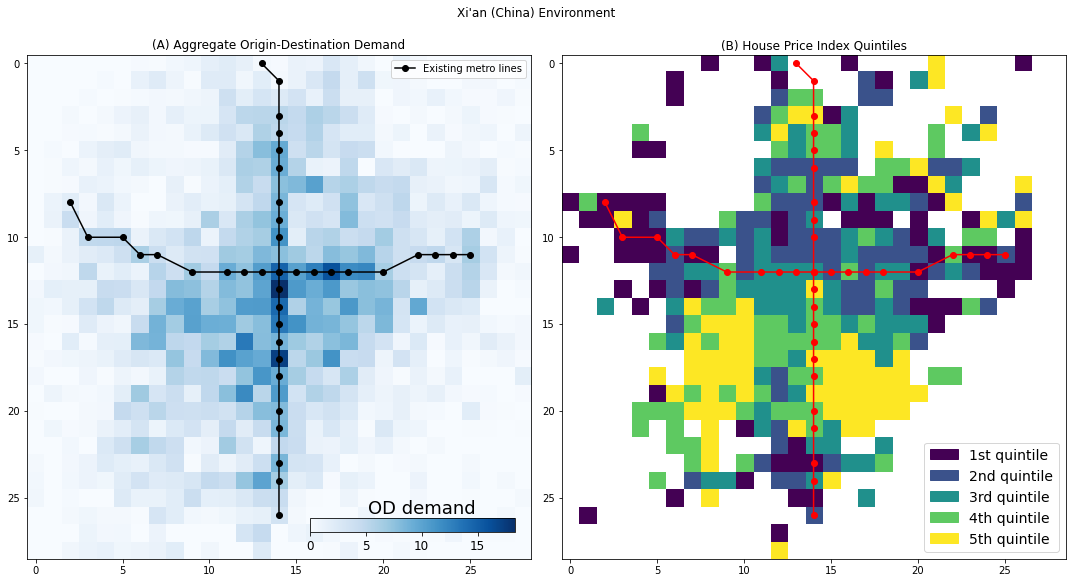

In [5]:
# def get_cax(ax):
#     divider = make_axes_locatable(ax)
#     return divider.append_axes('right', size='5%', pad=0.1)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(xian_od, cm.get_cmap('Blues'))
axs[0].set_title('(A) Aggregate Origin-Destination Demand')
cax = fig.add_axes([0.29, 0.17, 0.19, 0.02])
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal')
# cbar.set_label('test', horizontalalignment='right')
cax.text(5.2,1.3, 'OD demand', fontsize=18)
cax.tick_params(labelsize=12)

im1 = axs[1].imshow(xian_groups, cm.get_cmap('viridis'))
labels = ['1st quintile', '2nd quintile', '3rd quintile', '4th quintile', '5th quintile']
values = (np.unique(xian_groups[~np.isnan(xian_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower right", prop={'size': 14})
axs[1].set_title('(B) House Price Index Quintiles')
# fig.colorbar(im1, cax=get_cax(axs[1]), orientation='vertical')

for i, l in enumerate(xian.existing_lines):
    l_v = xian.vector_to_grid(l.T).cpu()
    # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
    label = "_no_legend"
    if i == 0:
        label = "Existing metro lines"

    axs[0].plot(l_v[1], l_v[0], '-ok', label=label)
    axs[1].plot(l_v[1], l_v[0], '-or', label=label)

axs[0].legend()

fig.suptitle("Xi'an (China) Environment", y=0.9)
fig.tight_layout()

/tmp/ipykernel_12852/1743912825.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


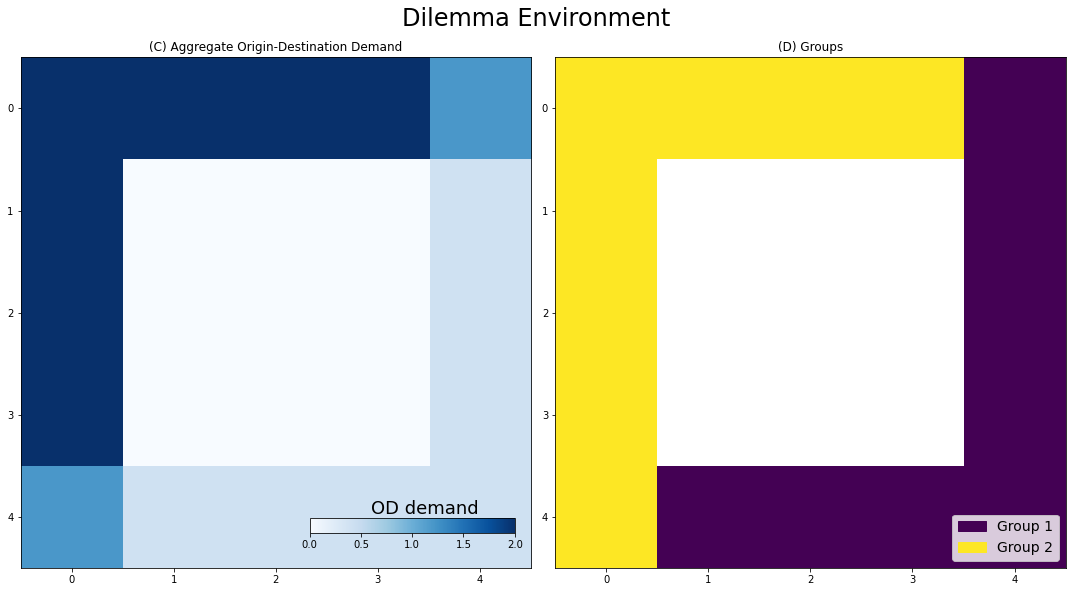

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(dilemma_od, cm.get_cmap('Blues'))
cax = fig.add_axes([0.29, 0.17, 0.19, 0.02])
fig.colorbar(im0, cax=cax, orientation='horizontal')
axs[0].set_title('(C) Aggregate Origin-Destination Demand')
cax.text(0.6,1.3, 'OD demand', fontsize=18)

im1 = axs[1].imshow(dilemma_groups, cm.get_cmap('viridis'))
labels = ['Group 1', 'Group 2']
values = (np.unique(dilemma_groups[~np.isnan(dilemma_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower right", prop={'size': 14})
axs[1].set_title('(D) Groups')

fig.suptitle("Dilemma Environment", y=0.9, fontsize=24)
fig.tight_layout()

## Diamond environment

/tmp/ipykernel_12852/1615745541.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


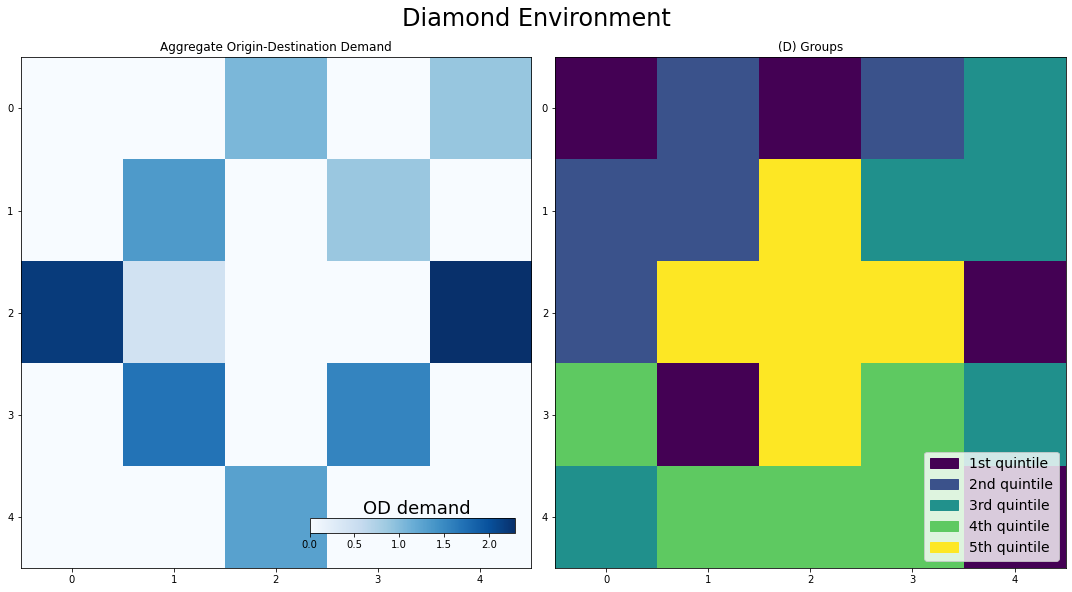

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(diamond_od, cm.get_cmap('Blues'))
cax = fig.add_axes([0.29, 0.17, 0.19, 0.02])
fig.colorbar(im0, cax=cax, orientation='horizontal')
axs[0].set_title('Aggregate Origin-Destination Demand')
cax.text(0.6,1.3, 'OD demand', fontsize=18)

im1 = axs[1].imshow(diamond_groups, cm.get_cmap('viridis'))
labels = ['1st quintile', '2nd quintile', '3rd quintile', '4th quintile', '5th quintile']
values = (np.unique(diamond_groups[~np.isnan(diamond_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower right", prop={'size': 14})
axs[1].set_title('(D) Groups')

fig.suptitle("Diamond Environment", y=0.9, fontsize=24)
fig.tight_layout()

/tmp/ipykernel_12852/210312292.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


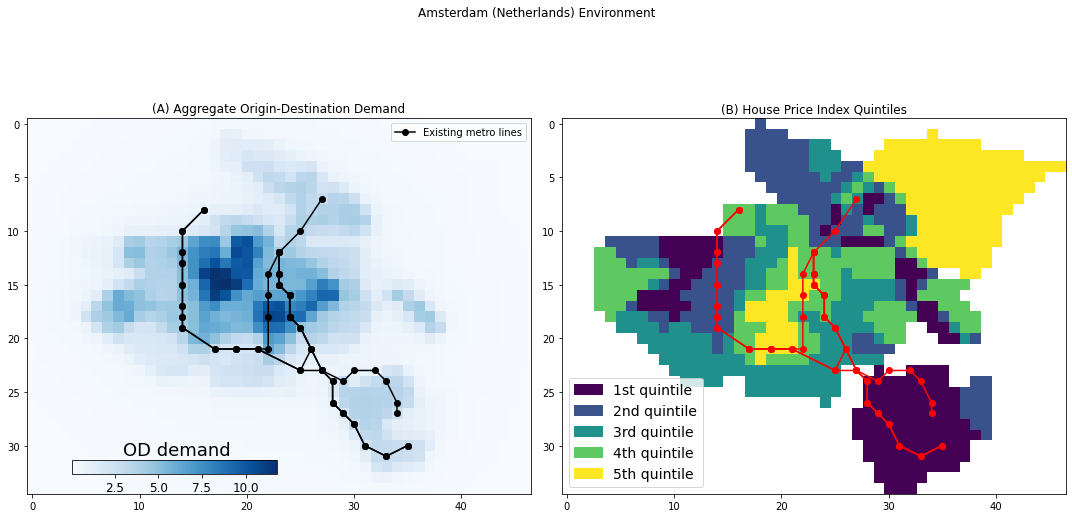

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(ams_od, cm.get_cmap('Blues'))
axs[0].set_title('(A) Aggregate Origin-Destination Demand')
cax = fig.add_axes([0.07, 0.25, 0.19, 0.02])
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal')
# cbar.set_label('test', horizontalalignment='right')
cax.text(3,1.3, 'OD demand', fontsize=18)
cax.tick_params(labelsize=12)

im1 = axs[1].imshow(ams_groups, cm.get_cmap('viridis'))
labels = ['1st quintile', '2nd quintile', '3rd quintile', '4th quintile', '5th quintile']
values = (np.unique(ams_groups[~np.isnan(ams_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower left", prop={'size': 14})
axs[1].set_title('(B) House Price Index Quintiles')
# fig.colorbar(im1, cax=get_cax(axs[1]), orientation='vertical')

for i, l in enumerate(amsterdam.existing_lines):
    l_v = amsterdam.vector_to_grid(l.T).cpu()
    # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
    label = "_no_legend"
    if i == 0:
        label = "Existing metro lines"

    axs[0].plot(l_v[1], l_v[0], '-ok', label=label)
    axs[1].plot(l_v[1], l_v[0], '-or', label=label)

axs[0].legend()

fig.suptitle("Amsterdam (Netherlands) Environment", y=0.9)
fig.tight_layout()

In [9]:
# fig, axs = plt.subplots(figsize=(15, 10))

# im0 = axs.imshow(ams_od, cm.get_cmap('Blues'))
# axs.set_title('(A) Aggregate Origin-Destination Demand')
# # cax = fig.add_axes([0.07, 0.25, 0.19, 0.02])
# # cbar = fig.colorbar(im0, cax=cax, orientation='horizontal')
# # # cbar.set_label('test', horizontalalignment='right')
# # cax.text(3,1.3, 'OD demand', fontsize=18)
# # cax.tick_params(labelsize=12)

# # im1 = axs.imshow(ams_groups, cm.get_cmap('viridis'))
# # labels = ['1st quintile', '2nd quintile', '3rd quintile', '4th quintile', '5th quintile']
# # values = (np.unique(ams_groups[~np.isnan(ams_groups)]))
# # colors = [ im1.cmap(im1.norm(value)) for value in values]
# # patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
# # axs.legend(handles=patches, loc="lower left", prop={'size': 14})
# # axs.set_title('(B) House Price Index Quintiles')
# # # fig.colorbar(im1, cax=get_cax(axs[1]), orientation='vertical')

# for i, l in enumerate(amsterdam.existing_lines[4]):
#     l_v = amsterdam.vector_to_grid(l.T).cpu()
#     # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
#     label = "_no_legend"
#     if i == 0:
#         label = "Existing metro lines"

#     axs.plot(l_v[1], l_v[0], '-ok', label=label)

# fig.tight_layout()


# lines_full = [
#     [[8, 16], [9, 15], [10, 14], [10, 14], [11, 14], [12, 14], [12, 14], [13, 14], [14, 14], [15, 14], [15, 14], [16, 14], [17, 14], [17, 14], [18, 14], [19, 14], [20, 15], [20, 16], [21, 17], [21, 17], [21, 18], [21, 19], [21, 19], [21, 20], [21, 21], [21, 21], [22, 22], [22, 23], [22, 24], [23, 25], [23, 25], [23, 26], [23, 27], [23, 27], [24, 28], [25, 28], [26, 28], [26, 28], [27, 29], [28, 30], [29, 30], [30, 31], [30, 31], [30, 32], [31, 33], [31, 33], [30, 34], [30, 35]],
#     [[8, 16], [9, 15], [10, 14], [10, 14], [11, 14], [12, 14], [12, 14], [13, 14], [14, 14], [15, 14], [15, 14], [16, 14], [17, 14], [17, 14], [18, 14], [19, 14], [20, 15], [20, 16], [21, 17], [21, 17], [21, 18], [21, 19], [21, 19], [21, 20], [21, 21], [21, 21], [22, 22], [22, 23], [22, 24], [23, 25], [23, 25], [22, 25], [21, 26], [21, 26], [20, 25], [19, 25], [19, 25], [18, 24], [17, 24], [16, 24], [16, 24], [15, 23], [14, 23], [13, 23], [12, 23]],
#     [[7, 27], [8, 26], [9, 26], [8, 26], [10, 25], [10, 25], [11, 24], [12, 23], [12, 23], [13, 22], [14, 22], [14, 22], [15, 22], [16, 22], [16, 22], [17, 22], [18, 22], [18, 22], [19, 22], [20, 22], [19, 22], [21, 22], [21, 22], [21, 20], [21, 21], [21, 19]],
#     [[12, 23], [13, 23], [14, 23], [14, 23], [15, 23], [16, 24], [17, 24], [18, 24], [18, 24], [19, 25], [20, 25], [21, 26], [21, 26], [22, 26], [23, 27], [23, 27], [23, 28], [24, 29], [24, 29], [23, 30], [23, 31], [23, 32], [23, 32], [24, 33], [25, 33], [26, 34], [26, 34]],
#     [[12, 23], [13, 23], [14, 23], [14, 23], [15, 23], [16, 24], [17, 24], [18, 24], [18, 24], [19, 25], [20, 25], [21, 26], [21, 26], [22, 26], [23, 27], [23, 27], [24, 28], [25, 28], [26, 28], [26, 28], [27, 29], [28, 30], [29, 30], [30, 31], [30, 31], [30, 32], [31, 33], [31, 33], [30, 34], [30, 35]]
# ]

# fig, axs = plt.subplots(figsize=(15, 10))

# im0 = axs.imshow(ams_od, cm.get_cmap('Blues'))
# axs.set_title('(A) Aggregate Origin-Destination Demand')

# for i, l in enumerate(lines_full[4]):
#     # l_v = amsterdam.vector_to_grid(l.T).cpu()
#     # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
#     label = "_no_legend"
#     if i == 0:
#         label = "Existing metro lines"

#     axs.plot(l[1], l[0], '-ok', label=label)

# fig.tight_layout()